# Exploration of 2023 Labels 

* Data annotated by Simon Geikie July/August 2023
* Data sourced for Ordnance Survey July/August 2023

| **Key**                     | **Meaning**                                                             |
|-----------------------------|-------------------------------------------------------------------------|
| A: Present                  | Present in OS data \| Present in the 2023 AP \| Present in 2014 AP      |
| B: Absent                   | Present in OS data \| Absent in the 2023 AP \| Absent in 2014 AP        |
| C: Absent (Present in 2014) | Absent in OS data \| Absent in the 2023 AP \| Present in 2014 AP        |
| E: Obscured (Vegetation)    | Obscured by trees, scrub or long grass.                                 |
| H: Urban                    | A mask created to simplify the detection of walls to only the open landscape |

In [1]:
# load libraries 
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point, GeometryCollection

In [2]:
# load data
walls = gpd.read_file("../content/labels/Walls.shp")
walls.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

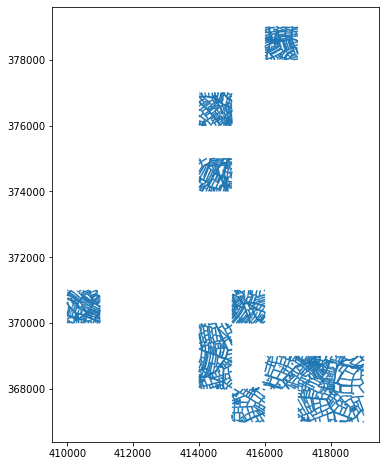

In [3]:
# take a look
walls.plot(figsize=(8,8))

In [4]:
walls.head(10)

,osid,toid,Label_2023,theme,istidal,changetype,ishistoric,isobscured,descriptio,versiondat,...,capturespe,geometry_e,descript_2,versionava,firstdigit,descript_3,versiona_1,FID_1,Shape_Leng,geometry
0,d4e434d7-ab01-49d6-af83-d747e155abae,osgb5000005154743092,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-04-17,2014-07-24,2022-08-27T00:00:00Z,0.0,0.666023,"LINESTRING (415354.513 367005.429, 415354.887 ..."
1,d4e434d7-ab01-49d6-af83-d747e155abae,osgb5000005154743092,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-04-17,2014-07-24,2022-08-27T00:00:00Z,0.0,0.666023,"LINESTRING (415354.513 367005.429, 415354.887 ..."
2,b2b57f92-a81a-457c-a885-f395a15f52f5,osgb5000005154737462,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-05-18,2014-07-24,2022-08-27T00:00:00Z,0.0,0.841807,"LINESTRING (415354.513 367005.429, 415353.804 ..."
3,b2b57f92-a81a-457c-a885-f395a15f52f5,osgb5000005154737462,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-05-18,2014-07-24,2022-08-27T00:00:00Z,0.0,0.841807,"LINESTRING (415354.513 367005.429, 415353.804 ..."
4,f07b364e-a9f8-40ec-ba22-350965ee82d7,osgb1000000108287641,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2005-10-04,2005-10-04,None,1994-07-26,2005-10-04,2022-08-27T00:00:00Z,0.0,14.492323,"LINESTRING (415372.330 367010.830, 415359.465 ..."
5,f07b364e-a9f8-40ec-ba22-350965ee82d7,osgb1000000108287641,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2005-10-04,2005-10-04,None,1994-07-26,2005-10-04,2022-08-27T00:00:00Z,0.0,14.492323,"LINESTRING (415372.330 367010.830, 415359.465 ..."
6,abf357f0-e072-426e-9c86-5b4bcf240535,osgb1000000108286955,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2005-10-04,2005-10-04,None,1994-07-26,2005-10-04,2022-08-27T00:00:00Z,0.0,27.612122,"LINESTRING (415344.890 367019.610, 415332.940 ..."
7,abf357f0-e072-426e-9c86-5b4bcf240535,osgb1000000108286955,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2005-10-04,2005-10-04,None,1994-07-26,2005-10-04,2022-08-27T00:00:00Z,0.0,27.612122,"LINESTRING (415344.890 367019.610, 415332.940 ..."
8,5c18cdef-cc0d-4a3f-be2a-c695281cb833,osgb5000005326924414,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2023-08-03,...,Rural,2023-04-04,2023-08-01,None,2023-08-01,2023-04-04,2023-08-04T00:00:00Z,0.0,17.137762,"LINESTRING (415344.890 367019.610, 415348.891 ..."
9,5c18cdef-cc0d-4a3f-be2a-c695281cb833,osgb5000005326924414,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2023-08-03,...,Rural,2023-04-04,2023-08-01,None,2023-08-01,2023-04-04,2023-08-04T00:00:00Z,0.0,17.137762,"LINESTRING (415344.890 367019.610, 415348.891 ..."


In [12]:
groups = walls['Label_2023'].unique()
groups

array(['H: Urban', 'Present (on MM and 2022 AP)',
       'Obscured (shadows and vegetation)',
       'Absent (present on MM but absent form 2022 AP)',
       'Absent (absent on MM present on 2014 AP)'], dtype=object)